## Electricity Price Project Data-camp 

# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.

Your company's pricing committee wants your team to estimate energy prices for the next 12-18 months to use those prices as the basis for contract negotiations.

In addition, the VP of strategy is researching investing in storage capacity (i.e., batteries) as a new source of revenue. The plan is to store some of the energy produced by the solar panels when pricing conditions are unfavorable and sell it by the next day on the open market if the prices are higher.

## 💪 Competition challenge

Create a report that covers the following:

1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?
2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.
3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

## 💾 The data
You have access to over five years of energy price and demand data ([source](https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia)):

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

In [10]:
# Import package and tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#SKlearn: XGBoosts, LabelEncoder
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

#Prophet
!pip install pystan==2.19.1.1 prophet

In [11]:
from prophet import Prophet

## EDA (Inspection, data profiling and visualization)

In [12]:
#Import data
df = pd.read_csv(r'/Users/pawinee/Documents/Health Tech Dev/3.Basic Programming/GitHub/Basic-programming/complete_dataset.csv')
df.columns = df.columns.str.replace('RRP', 'price') # replace column name 'RRP' with 'price'
df.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_at_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [3]:
# Check data D type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               2106 non-null   object 
 1   demand             2106 non-null   float64
 2   price              2106 non-null   float64
 3   demand_pos_price   2106 non-null   float64
 4   price_positive     2106 non-null   float64
 5   demand_neg_price   2106 non-null   float64
 6   price_negative     2106 non-null   float64
 7   frac_at_neg_price  2106 non-null   float64
 8   min_temperature    2106 non-null   float64
 9   max_temperature    2106 non-null   float64
 10  solar_exposure     2105 non-null   float64
 11  rainfall           2103 non-null   float64
 12  school_day         2106 non-null   object 
 13  holiday            2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB


Found datetime64 at ['date']\
Found missing data at ['solar_exposure','rainfall']

> Prepare data
1. convert date column to datetime
2. fill missing values 
	- 'rainfall' -> Rain = number, no rain = '0' -> if no data -> imply no rain = '0' 
    - 'solar_exposure' -> some value -> if no data -> interpolate (ประมาณค่ากลาง)

In [13]:
# Convert 'date' column to datetime64
df.date = pd.to_datetime(df.date) 

# Fill missing value on 'solar_exposure' and 'rainfall'
df['rainfall'] = df.fillna(0)['rainfall'] # Replace ['rainfall'] NaN elements with 0s.
df['solar_exposure'] = df['solar_exposure'].interpolate() # Filling in NaN in a ['solar_exposure'] via linear interpolation.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               2106 non-null   datetime64[ns]
 1   demand             2106 non-null   float64       
 2   price              2106 non-null   float64       
 3   demand_pos_price   2106 non-null   float64       
 4   price_positive     2106 non-null   float64       
 5   demand_neg_price   2106 non-null   float64       
 6   price_negative     2106 non-null   float64       
 7   frac_at_neg_price  2106 non-null   float64       
 8   min_temperature    2106 non-null   float64       
 9   max_temperature    2106 non-null   float64       
 10  solar_exposure     2106 non-null   float64       
 11  rainfall           2106 non-null   float64       
 12  school_day         2106 non-null   object        
 13  holiday            2106 non-null   object        
dtypes: datet

> LabelEncoder 

Change 'object' Dtype to 'float'

In [16]:
le = LabelEncoder()
df1 = df.loc[:,['school_day','holiday']] # df1 = DataFrame subset of df
df1['school_day'] = le.fit_transform(df['school_day'])
df1['holiday'] = le.fit_transform(df['holiday'])
df1['school_day'].value_counts()

1    1453
0     653
Name: school_day, dtype: int64

In [20]:
#put float data to df
df['school_day'] = df1['school_day']
df['holiday'] = df1['holiday']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               2106 non-null   datetime64[ns]
 1   demand             2106 non-null   float64       
 2   price              2106 non-null   float64       
 3   demand_pos_price   2106 non-null   float64       
 4   price_positive     2106 non-null   float64       
 5   demand_neg_price   2106 non-null   float64       
 6   price_negative     2106 non-null   float64       
 7   frac_at_neg_price  2106 non-null   float64       
 8   min_temperature    2106 non-null   float64       
 9   max_temperature    2106 non-null   float64       
 10  solar_exposure     2106 non-null   float64       
 11  rainfall           2106 non-null   float64       
 12  school_day         2106 non-null   int64         
 13  holiday            2106 non-null   int64         
dtypes: datet

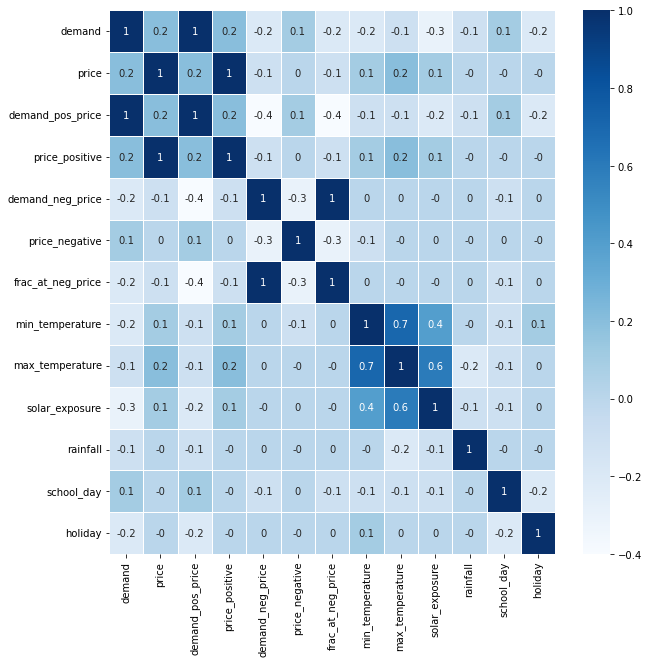

In [98]:
# Remove redundant cells - not useful data for price prediction
sns.heatmap(round(df.corr(),1),annot=True,cmap='Blues',linewidth=0.9)
plt.show();

> Data vitualization

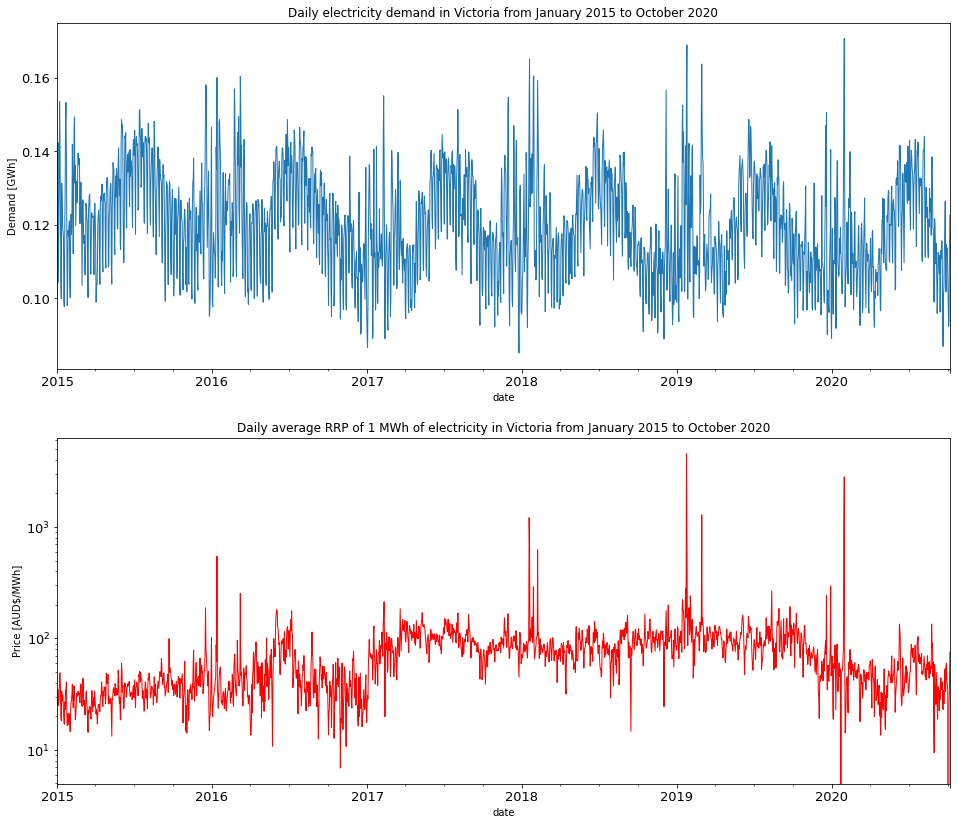

In [25]:
fig, ax = plt.subplots(2, 1, figsize = (16, 14))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[1].tick_params(axis='both', which='major', labelsize=13)

df['demand'] = df['demand'] / 1000
df.plot(x='date', y='demand', lw = 1, ax = ax[0])
df['demand'] = df['demand'] * 1000 # Gigawatt hours (GWh = 1 billion watts/hr)
ax[0].set_title("Daily electricity demand in Victoria from January 2015 to October 2020")
ax[0].set_ylabel("Demand [GWh]") 
ax[0].get_legend().remove()

df.plot(x='date', y='price', lw = 1, color='red', ax = ax[1])
ax[1].set_title("Daily average RRP of 1 MWh of electricity in Victoria from January 2015 to October 2020")
ax[1].set_ylabel("Price [AUD$/MWh]")
ax[1].get_legend().remove()
plt.yscale("log") 

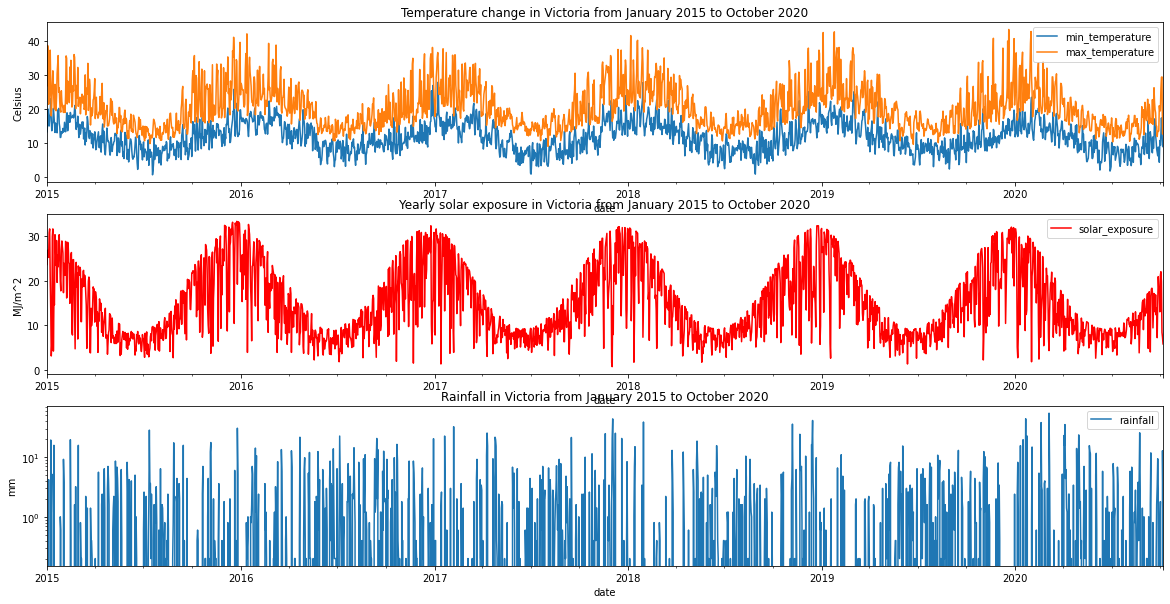

In [73]:
# Comparing 'Min-Max temperature' showing seasonal data
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
df.plot(x='date', y=['min_temperature', 'max_temperature'], ax=axs[0])
axs[0].set_title('Temperature change in Victoria from January 2015 to October 2020')
axs[0].set_ylabel("Celsius") 

# Showing solar exposure
df.plot(x='date', y='solar_exposure', ax=axs[1], color='red')
axs[1].set_title('Yearly solar exposure in Victoria from January 2015 to October 2020')
axs[1].set_ylabel('MJ/m^2') 

# Showing rainny season
df.plot(x='date', y='rainfall', ax=axs[2])
axs[2].set_title('Rainfall in Victoria from January 2015 to October 2020')
axs[2].set_ylabel('mm') 
plt.yscale("log") 

plt.show()

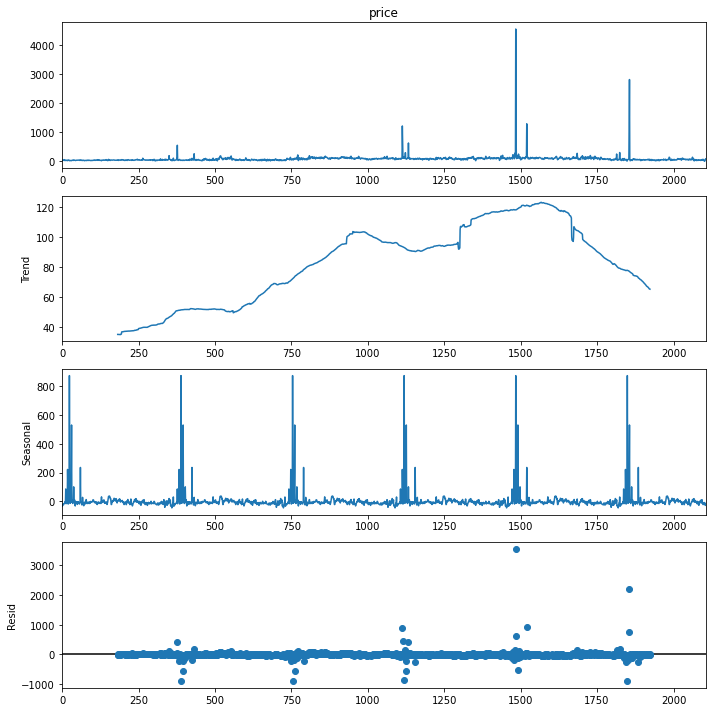

In [96]:
# SEASONAL DECOMPOSE

from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (10, 10)

T = 365 # days in a year
decompose = seasonal_decompose(x=df['price'], period=T, model='additive')
decompose.plot()
None

# 💪 Competition Challenge
#### 1.1 How do energy prices change throughout the year? 
#### 1.2 Are there any patterns by season or month of the year?

# 💪 Competition Challenge
#### 2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.

In [100]:
def d2i(timed):
    ''' function input datedelta64 return int'''
    string = str(timed) # change type Timedelta to str
    lst = string.split(' ') # เเยก string ยาวๆ ด้วย ' '
    lst_int = int(lst[0])
    return lst_int

start_date = df['date'].min()
temp = df.loc[:,'date']-start_date
df['days'] = temp.apply(lambda x: d2i(x)) # lambda(input: output)
df['days']

0          0
1          1
2          2
3          3
4          4
        ... 
2101    2101
2102    2102
2103    2103
2104    2104
2105    2105
Name: days, Length: 2106, dtype: int64

In [160]:
start_date = df['date'].min() # วันเเรก

def create_features(df, label=None):
    temp = df.loc[:,'date']-start_date
    df['days'] = temp.apply(lambda x: d2i(x))
    df['price'] = df['price']
    df['solar_exposure'] = df['solar_exposure']
    df['min_temperature'] = df['min_temperature']
    df['max_temperature'] = df['max_temperature']
    df['price_7_days_lag'] = df['price'].shift(7) 
    df['price_15_days_lag'] = df['price'].shift(15)
    df['price_30_days_lag'] = df['price'].shift(30)
    df['price_7_days_mean'] = df['price'].rolling(window = 7).mean()
    df['price_15_days_mean'] = df['price'].rolling(window = 15).mean()
    df['price_30_days_mean'] = df['price'].rolling(window = 30).mean()
    df['price_7_days_std'] = df['price'].rolling(window = 7).std()
    df['price_15_days_std'] = df['price'].rolling(window = 15).std()
    df['price_30_days_std'] = df['price'].rolling(window = 30).std()
    df['price_7_days_max'] = df['price'].rolling(window = 7).max()
    df['price_15_days_max'] = df['price'].rolling(window = 15).max()
    df['price_30_days_max'] = df['price'].rolling(window = 30).max()
    df['price_7_days_min'] = df['price'].rolling(window = 7).min()
    df['price_15_days_min'] = df['price'].rolling(window = 15).min()
    df['price_30_days_min'] = df['price'].rolling(window = 30).min()
    df['holiday'] = df['holiday']
    df['school_day'] = df['school_day']
    df['solar_exposure_7_lag'] = df["solar_exposure"].shift(7)
    df['solar_exposure_15_lag'] = df["solar_exposure"].shift(15)
    df['solar_exposure_30_lag'] = df["solar_exposure"].shift(30)
    df['solar_exposure_30_mean'] = df['solar_exposure'].rolling(window = 30).mean()
    df['solar_exposure_7_mean'] = df['solar_exposure'].rolling(window = 7).mean()
    df['solar_exposure_15_mean'] = df['solar_exposure'].rolling(window = 15).mean()
    df['solar_exposure_30_std'] = df['solar_exposure'].rolling(window = 30).std()
    df['solar_exposure_7_std'] = df['solar_exposure'].rolling(window = 7).std()
    df['solar_exposure_15_std'] = df['solar_exposure'].rolling(window = 15).std()
    df['solar_exposure_30_min'] = df['solar_exposure'].rolling(window = 30).min()
    df['solar_exposure_15_min'] = df['solar_exposure'].rolling(window = 15).min()
    df['solar_exposure_7_min'] = df['solar_exposure'].rolling(window = 7).min()
    df['solar_exposure_30_max'] = df['solar_exposure'].rolling(window = 30).max()
    df['solar_exposure_15_max'] = df['solar_exposure'].rolling(window = 15).max()
    df['solar_exposure_7_max'] = df['solar_exposure'].rolling(window = 7).max()
    

    cols = ['days','price', 'solar_exposure', 'min_temperature','max_temperature','holiday', 'school_day']
    
        
    for d in ('7', '15', '30'):
        for c in ('lag', 'mean', 'std', 'max', 'min'):
            cols.append(f'price_{d}_days_{c}')
            cols.append(f'solar_exposure_{d}_{c}')
     

    X = df[cols]
    if label:
        y = df[label]
        return X, y
    return X

In [161]:
# At the latest year '2020' starting from Jan #1826
print(df['date'][1826]) 
split_date = df['days'][1826]  
split_date

# split_date = '01-Jan-2020' -----> Run ไม่ได้? 

2020-01-01 00:00:00


1826

In [162]:
# Define train vs test data by the split_date (starting Jan 2020)
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

#Create feature as filled above
X_train, y_train = create_features(df_train, label='price')
X_test, y_test = create_features(df_test, label='price')

#reg fit and train model
reg = xgb.XGBRegressor(n_estimators=200) ###### หาวิธี predict วันที่ต้องการ เช่น reg.predict ----> หาค่า x มาใส่
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) 

[0]	validation_0-rmse:114.90650	validation_1-rmse:163.99835
[1]	validation_0-rmse:92.83180	validation_1-rmse:148.67409
[2]	validation_0-rmse:75.86444	validation_1-rmse:137.03647
[3]	validation_0-rmse:62.56034	validation_1-rmse:128.08295
[4]	validation_0-rmse:51.96785	validation_1-rmse:121.08009
[5]	validation_0-rmse:43.32087	validation_1-rmse:115.01093
[6]	validation_0-rmse:36.28419	validation_1-rmse:110.43813
[7]	validation_0-rmse:30.51104	validation_1-rmse:107.21654
[8]	validation_0-rmse:25.72919	validation_1-rmse:104.53049
[9]	validation_0-rmse:21.74158	validation_1-rmse:102.39232
[10]	validation_0-rmse:18.40349	validation_1-rmse:100.68851
[11]	validation_0-rmse:15.60059	validation_1-rmse:99.38358
[12]	validation_0-rmse:13.24005	validation_1-rmse:98.28311
[13]	validation_0-rmse:11.25226	validation_1-rmse:97.40243
[14]	validation_0-rmse:9.56880	validation_1-rmse:96.53229
[15]	validation_0-rmse:8.13969	validation_1-rmse:95.80441
[16]	validation_0-rmse:6.92954	validation_1-rmse:95.1854

/Users/pawinee/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:1.31352	validation_1-rmse:92.25772
[28]	validation_0-rmse:1.16000	validation_1-rmse:92.17017
[29]	validation_0-rmse:1.03784	validation_1-rmse:92.09580
[30]	validation_0-rmse:0.93638	validation_1-rmse:92.03224
[31]	validation_0-rmse:0.85397	validation_1-rmse:91.97831
[32]	validation_0-rmse:0.78772	validation_1-rmse:91.93284
[33]	validation_0-rmse:0.73478	validation_1-rmse:91.89383
[34]	validation_0-rmse:0.69258	validation_1-rmse:91.86080
[35]	validation_0-rmse:0.66182	validation_1-rmse:91.83290
[36]	validation_0-rmse:0.63363	validation_1-rmse:91.80933
[37]	validation_0-rmse:0.61513	validation_1-rmse:91.79059
[38]	validation_0-rmse:0.59534	validation_1-rmse:91.77293
[39]	validation_0-rmse:0.57229	validation_1-rmse:91.75641
[40]	validation_0-rmse:0.55518	validation_1-rmse:91.74761
[41]	validation_0-rmse:0.53595	validation_1-rmse:91.74158
[42]	validation_0-rmse:0.51853	validation_1-rmse:91.73114
[43]	validation_0-rmse:0.51180	validation_1-rmse:91.72223
[44]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

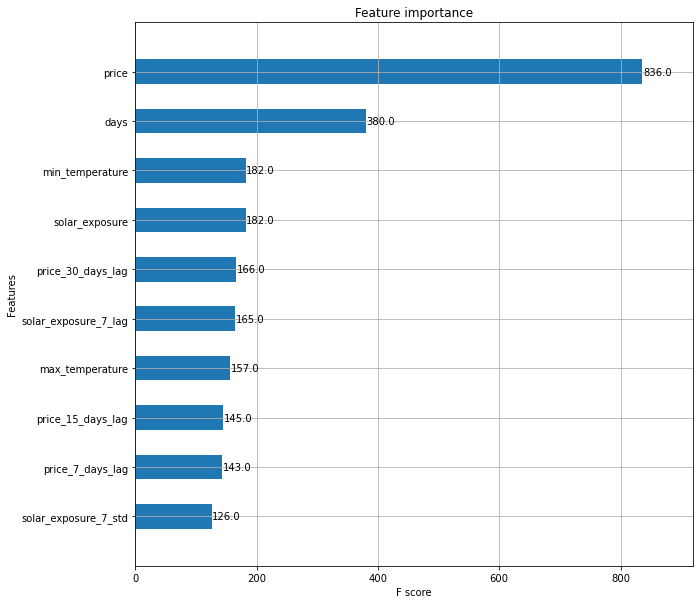

In [163]:
_ = plot_importance(reg, height=0.5 ,max_num_features = 10)

In [164]:
df_test['predict'] = reg.predict(X_test)

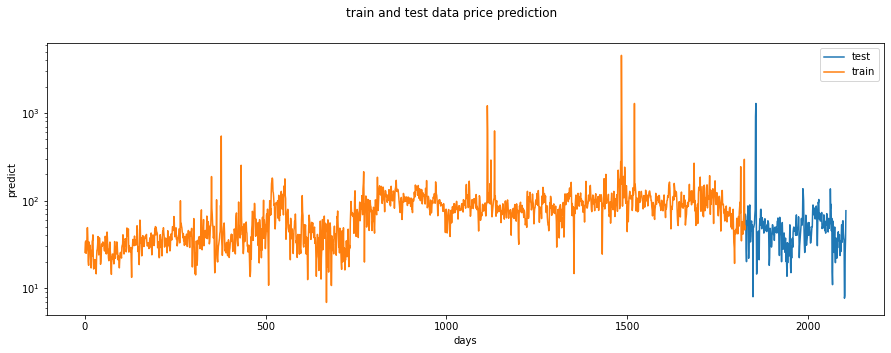

In [165]:
#Vitualize price prediction between train and test data
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_test, x ='days',y='predict',label='test')
sns.lineplot(data=df_train,x='days',y='price',label='train')
plt.yscale("log") 
plot = plt.suptitle('train and test data price prediction')
plt.show()

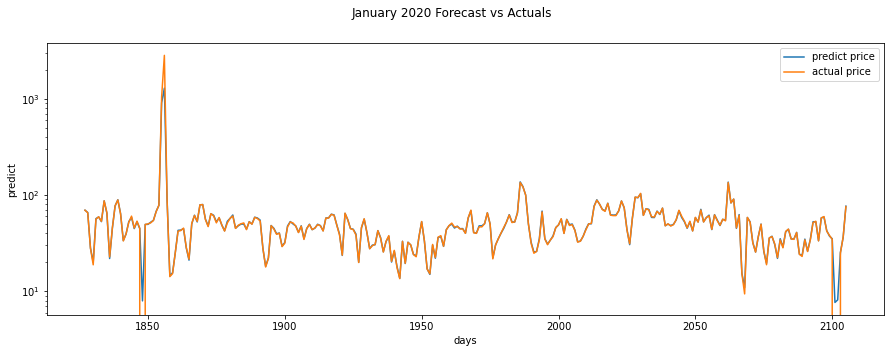

In [166]:
#Compare between actual and predict price in 'test' data
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_test, x ='days',y='predict',label='predict price')
sns.lineplot(data=df_test,x='days',y='price',label='actual price')
plt.yscale("log") 
plot = plt.suptitle('January 2020 Forecast vs Actuals')
plt.show()

In [168]:
#Check validity by r square
from sklearn.metrics import r2_score
r2_score(df_test['price'], df_test['predict'])

0.7298102934678996

# 💪 Competition Challenge
#### 3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

In [169]:
# Revenue = 70MWh/hr x 24 hr x price per MWh
df['revenue'] = df[['price']] *70*24
df.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_at_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,days,revenue
0,2015-01-01,99.635030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,0,1,0,43064.610009
1,2015-01-02,129.606010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,0,0,1,55673.499103
2,2015-01-03,142.300540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,0,0,2,58068.956113
3,2015-01-04,104.330715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,0,0,3,42009.341201
4,2015-01-05,118.132200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,0,0,4,44896.616147


In [223]:
def create_features(df, label=None):
    df['days'] = temp.apply(lambda x: d2i(x))
    df['min_temperature'] = df['min_temperature']
    df['max_temperature'] = df['max_temperature']
    df['revenue_7_days_lag'] = df['revenue'].shift(7) 
    df['revenue_15_days_lag'] = df['revenue'].shift(15)
    df['revenue_30_days_lag'] = df['revenue'].shift(30)
    df['revenue_7_days_mean'] = df['revenue'].rolling(window = 7).mean()
    df['revenue_15_days_mean'] = df['revenue'].rolling(window = 15).mean()
    df['revenue_30_days_mean'] = df['revenue'].rolling(window = 30).mean()
    df['revenue_7_days_std'] = df['revenue'].rolling(window = 7).std()
    df['revenue_15_days_std'] = df['revenue'].rolling(window = 15).std()
    df['revenue_30_days_std'] = df['revenue'].rolling(window = 30).std()
    df['revenue_7_days_max'] = df['revenue'].rolling(window = 7).max()
    df['revenue_15_days_max'] = df['revenue'].rolling(window = 15).max()
    df['revenue_30_days_max'] = df['revenue'].rolling(window = 30).max()
    df['revenue_7_days_min'] = df['revenue'].rolling(window = 7).min()
    df['revenue_15_days_min'] = df['revenue'].rolling(window = 15).min()
    df['revenue_30_days_min'] = df['revenue'].rolling(window = 30).min()
    df['holiday'] = df['holiday']
    df['school_day'] = df['school_day']
    df['solar_exposure_7_lag'] = df["solar_exposure"].shift(7)
    df['solar_exposure_15_lag'] = df["solar_exposure"].shift(15)
    df['solar_exposure_30_lag'] = df["solar_exposure"].shift(30)
    df['solar_exposure_30_mean'] = df['solar_exposure'].rolling(window = 30).mean()
    df['solar_exposure_7_mean'] = df['solar_exposure'].rolling(window = 7).mean()
    df['solar_exposure_15_mean'] = df['solar_exposure'].rolling(window = 15).mean()
    df['solar_exposure_30_std'] = df['solar_exposure'].rolling(window = 30).std()
    df['solar_exposure_7_std'] = df['solar_exposure'].rolling(window = 7).std()
    df['solar_exposure_15_std'] = df['solar_exposure'].rolling(window = 15).std()
    df['solar_exposure_30_min'] = df['solar_exposure'].rolling(window = 30).min()
    df['solar_exposure_15_min'] = df['solar_exposure'].rolling(window = 15).min()
    df['solar_exposure_7_min'] = df['solar_exposure'].rolling(window = 7).min()
    df['solar_exposure_30_max'] = df['solar_exposure'].rolling(window = 30).max()
    df['solar_exposure_15_max'] = df['solar_exposure'].rolling(window = 15).max()
    df['solar_exposure_7_max'] = df['solar_exposure'].rolling(window = 7).max()
    
    
    cols = ['days','price', 'solar_exposure', 'min_temperature','max_temperature', 'demand','holiday', 'school_day', 'revenue']

    
    for d in ('7', '15', '30'):
        for c in ('lag', 'mean', 'std', 'max', 'min'):
            cols.append(f'revenue_{d}_days_{c}')
            cols.append(f'solar_exposure_{d}_{c}')
            
    X = df[cols]
    if label:
        y = df[label]
        return X, y
    return X

In [224]:
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

X_train, y_train = create_features(df_train, label='revenue')
X_test, y_test = create_features(df_test, label='revenue')

reg = xgb.XGBRegressor(n_estimators=200)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) 

[0]	validation_0-rmse:193330.47583	validation_1-rmse:275683.86174
[1]	validation_0-rmse:156138.50412	validation_1-rmse:249874.37906
[2]	validation_0-rmse:127566.21853	validation_1-rmse:230285.66937
[3]	validation_0-rmse:105174.29321	validation_1-rmse:215221.29795
[4]	validation_0-rmse:87353.21778	validation_1-rmse:203442.26711
[5]	validation_0-rmse:72809.61246	validation_1-rmse:193237.41187
[6]	validation_0-rmse:60978.39196	validation_1-rmse:185549.47871
[7]	validation_0-rmse:51273.14839	validation_1-rmse:180133.39117
[8]	validation_0-rmse:43235.77856	validation_1-rmse:175618.64282
[9]	validation_0-rmse:36537.62903	validation_1-rmse:172024.48945
[10]	validation_0-rmse:30920.85834	validation_1-rmse:169160.07335
[11]	validation_0-rmse:26210.47022	validation_1-rmse:166967.77169
[12]	validation_0-rmse:22242.08775	validation_1-rmse:165115.79027
[13]	validation_0-rmse:18900.81977	validation_1-rmse:163638.27596
[14]	validation_0-rmse:16071.43811	validation_1-rmse:162177.42807
[15]	validation_

/Users/pawinee/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:1992.58794	validation_1-rmse:154830.24137
[29]	validation_0-rmse:1789.61938	validation_1-rmse:154704.94244
[30]	validation_0-rmse:1622.88439	validation_1-rmse:154600.12760
[31]	validation_0-rmse:1468.60955	validation_1-rmse:154510.28510
[32]	validation_0-rmse:1338.13813	validation_1-rmse:154433.98356
[33]	validation_0-rmse:1250.00718	validation_1-rmse:154370.24982
[34]	validation_0-rmse:1162.93177	validation_1-rmse:154314.55566
[35]	validation_0-rmse:1102.75507	validation_1-rmse:154267.55868
[36]	validation_0-rmse:1056.01969	validation_1-rmse:154224.60619
[37]	validation_0-rmse:1018.68381	validation_1-rmse:154215.93672
[38]	validation_0-rmse:990.50511	validation_1-rmse:154186.47023
[39]	validation_0-rmse:968.05336	validation_1-rmse:154178.09239
[40]	validation_0-rmse:928.91214	validation_1-rmse:154186.12240
[41]	validation_0-rmse:902.06237	validation_1-rmse:154189.83955
[42]	validation_0-rmse:881.82156	validation_1-rmse:154194.73645
[43]	validation_0-rmse:871.147

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

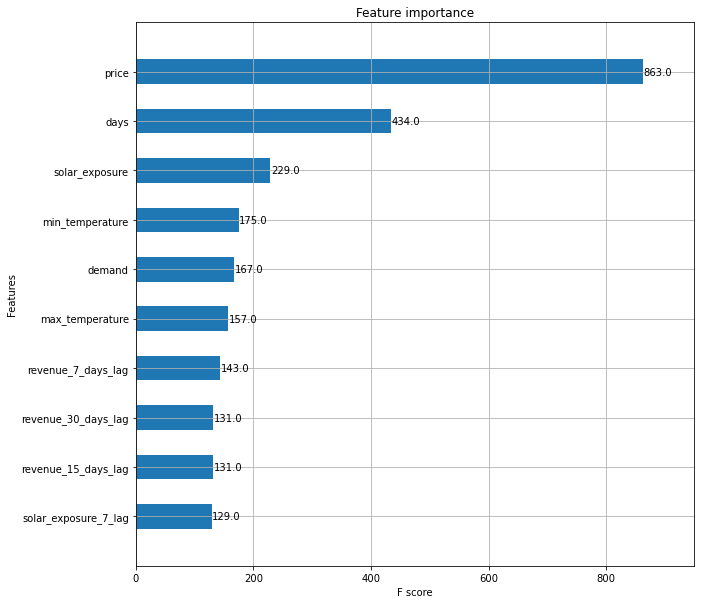

In [225]:
_ = plot_importance(reg, height=0.5 ,max_num_features = 10)

In [226]:
df_test['predict'] = reg.predict(X_test)


/Users/pawinee/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/pawinee/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


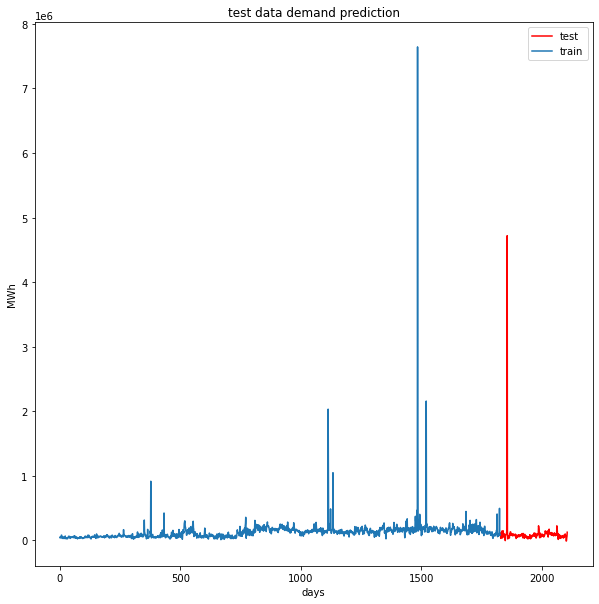

In [227]:
# plot train vs test df3
sns.lineplot(df_test['days'], df_test['revenue'], label='test', color='red')
sns.lineplot(df_train['days'], df_train['revenue'], label='train')
plt.title('test data demand prediction')
plt.ylabel("MWh") 

plt.show()

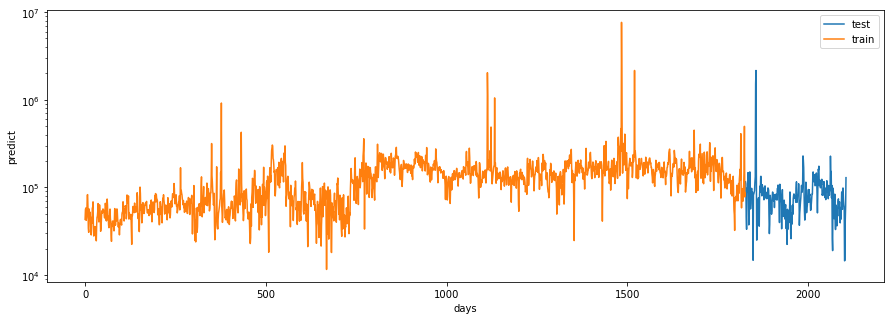

In [228]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_test, x ='days',y='predict',label='test')
sns.lineplot(data=df_train,x='days',y='revenue',label='train')
plt.yscale("log") 
plt.show()

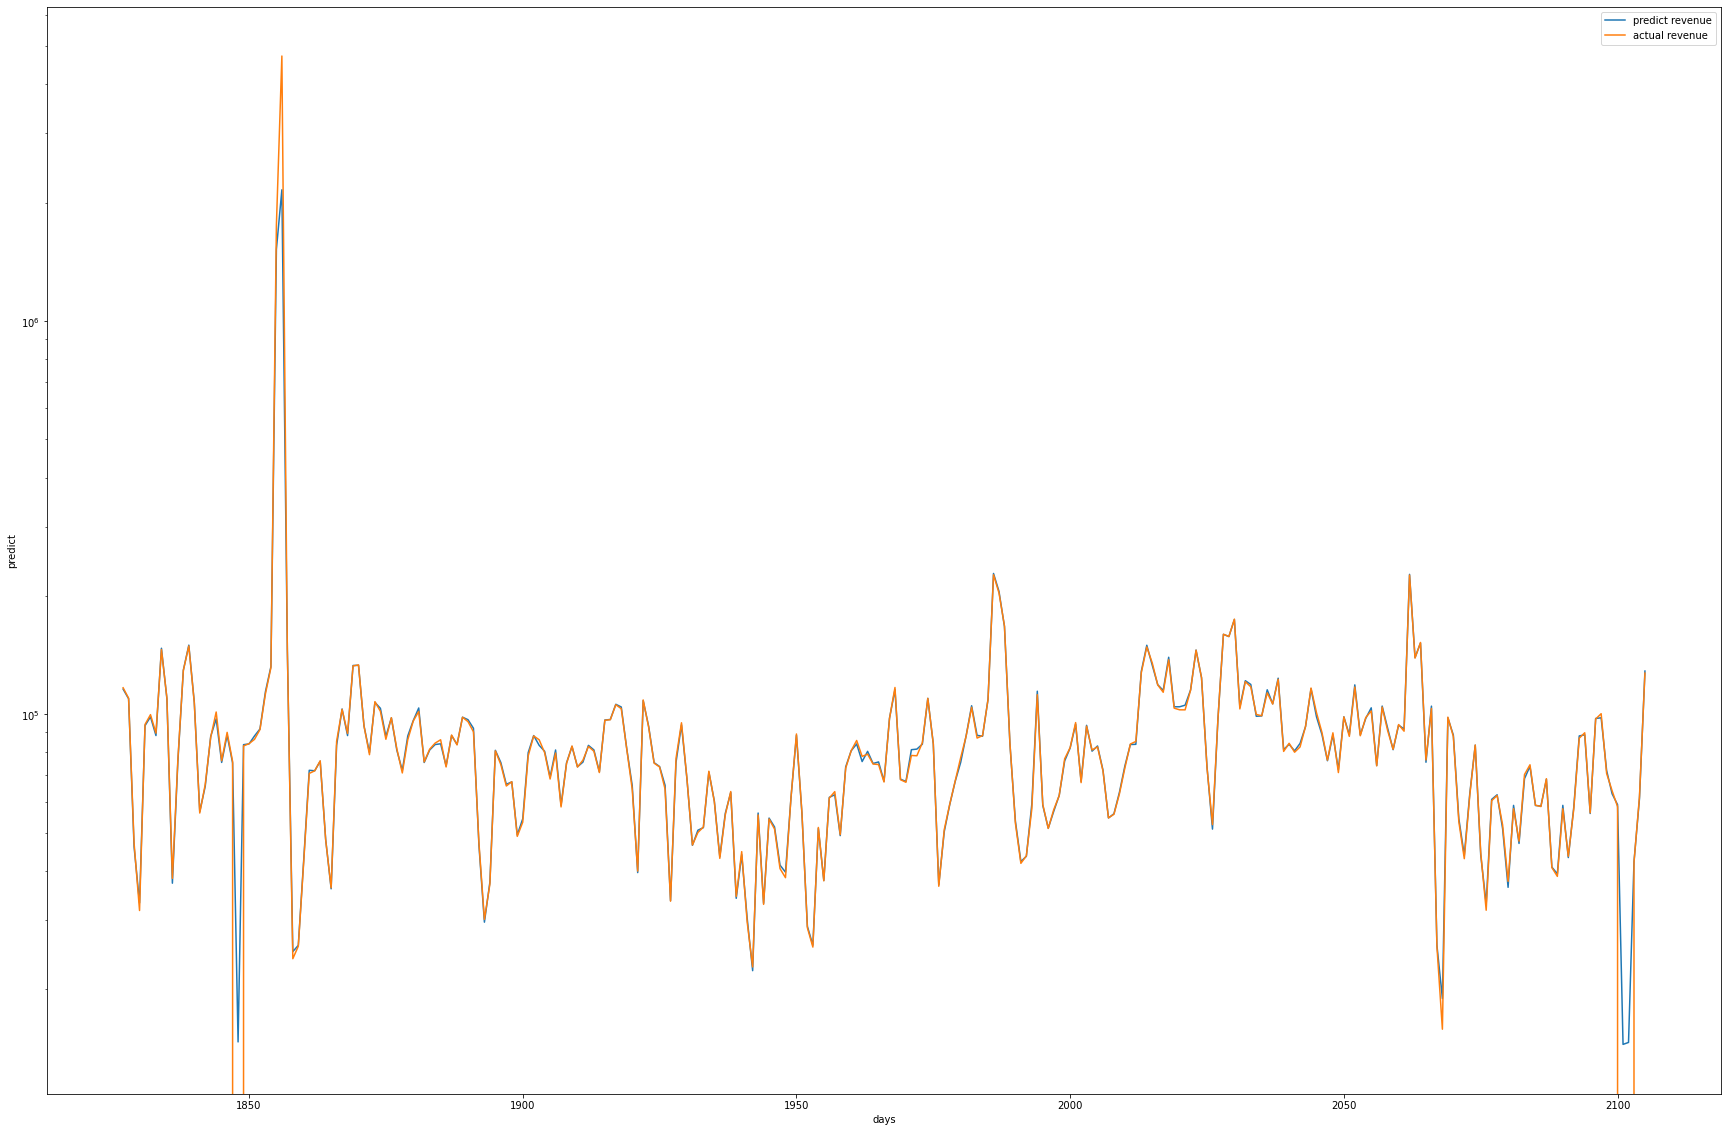

In [235]:
plt.figure(figsize=(30, 20))
sns.lineplot(data=df_test, x ='days',y='predict',label='predict revenue')
sns.lineplot(data=df_test,x='days',y='revenue',label='actual revenue')
plt.yscale("log") 
plt.show()

In [231]:
from sklearn.metrics import r2_score
r2_score(df_test['revenue'], df_test['predict'])

0.729504525365644